In [50]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from numpy import save, load
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

In [2]:
X = load('X_new.npy')
#y = load('y_new.npy')
pca_components = load('PCA_Components_new.npy')
columns = load('Columns_new.npy')
y = load('/Users/architmatta/Documents/Columbia/Fall 2021/Capstone/Data/final_data/classes_new.npy')

In [3]:
y_raw = load('y_raw.npy')

<AxesSubplot:ylabel='Frequency'>

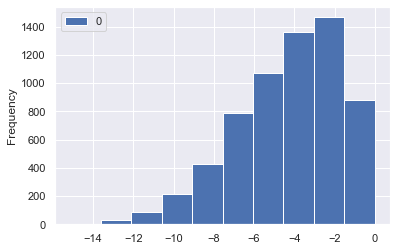

In [6]:
pd.DataFrame(np.log(y_raw)).plot(kind = 'hist')

In [37]:
y_raw = load('y_raw.npy')
y_raw_new = []
y_raw = np.log(y_raw)
for val in y_raw:
    if val <= -7:
        y_raw_new.append(4)
    elif val <= -5:
        y_raw_new.append(3)
    elif val <= -3:
        y_raw_new.append(2)
    elif val <= -1:
        y_raw_new.append(1)
    else:
        y_raw_new.append(0)
y = np.asarray(y_raw_new)

In [57]:
y_raw = load('y_raw.npy')
y = ((np.log(y_raw))/-3.03).astype(int)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7, stratify = y)

In [59]:
pd.DataFrame(y).value_counts()

1    2432
0    2353
2    1215
3     295
4      32
dtype: int64

## Decision Tree

In [72]:
a = time.time()
param_grid = {'criterion': ['gini','entropy'], 'max_depth': [25,50,75,100], 'min_samples_split': [5,10,15]}
grid = GridSearchCV(DecisionTreeClassifier(class_weight = "balanced"), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Time Taken: 29.31 seconds
Best Estimator: DecisionTreeClassifier(class_weight='balanced', max_depth=100,
                       min_samples_split=5)
Train F1 Score: 0.9159375486130416
Test F1 Score: 0.6489732919140361


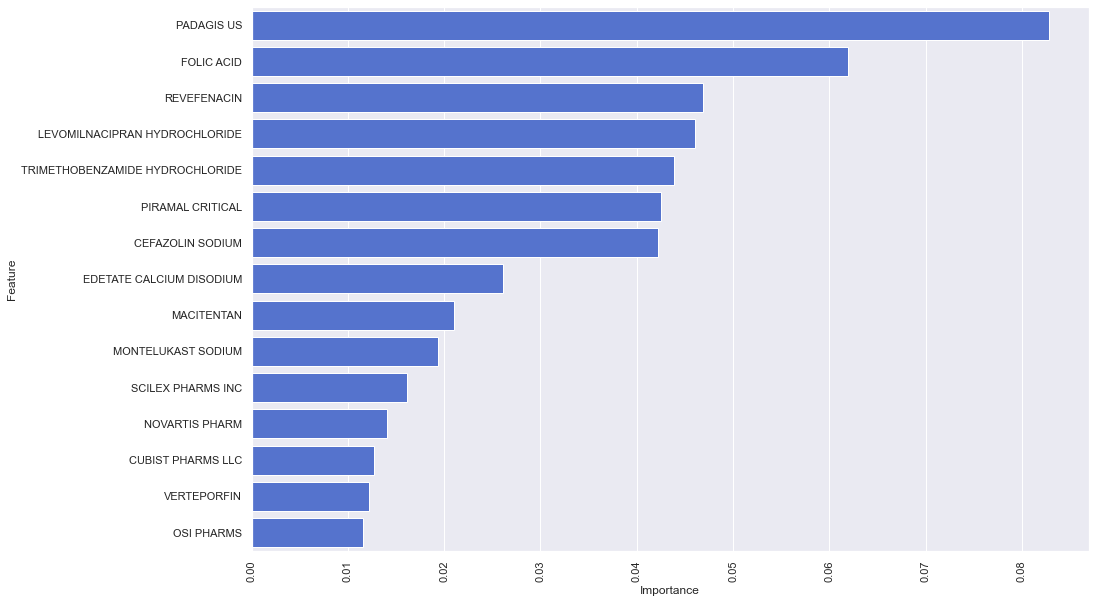

In [74]:
n = 15
indices = (-grid.best_estimator_.feature_importances_).argsort()[:n]
features = columns[indices]
weights = (grid.best_estimator_.feature_importances_)[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(y = 'Feature', x = 'Importance', data = df_temp, color = 'royalblue', orient = 'h');
plt.gcf().set_size_inches(15,10)
plt.xticks(rotation = 90);

## Random Forest

In [97]:
a = time.time()
param_grid = {'max_depth': [100,250,500], 'n_estimators': [500,1000,1500], 'max_features': [10,15,20,25]}
grid = GridSearchCV(RandomForestClassifier(class_weight = "balanced"), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Time Taken: 1152.29 seconds
Best Estimator: RandomForestClassifier(class_weight='balanced', max_depth=100, max_features=10,
                       n_estimators=500)
Train F1 Score: 0.9975197920434663
Test F1 Score: 0.690399492768589


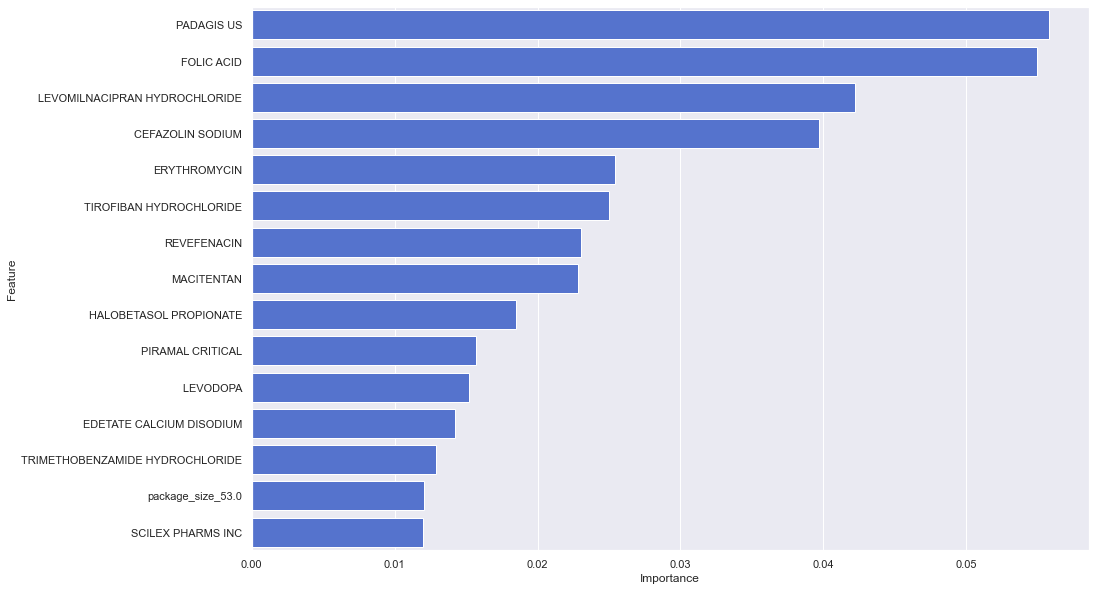

In [98]:
n = 15
indices = (-grid.best_estimator_.feature_importances_).argsort()[:n]
features = columns[indices]
weights = (grid.best_estimator_.feature_importances_)[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(y = 'Feature', x = 'Importance', data = df_temp, color = 'royalblue', orient = 'h');
plt.gcf().set_size_inches(15,10)
#plt.xticks(rotation = 90);

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Very Rare','Rare','Infrequent','Frequent','Very Frequent'], 
                     columns = ['Very Rare','Rare','Infrequent','Frequent','Very Frequent'])
cm_df_new = (cm_df.div(cm_df.sum(axis=1), axis=0))

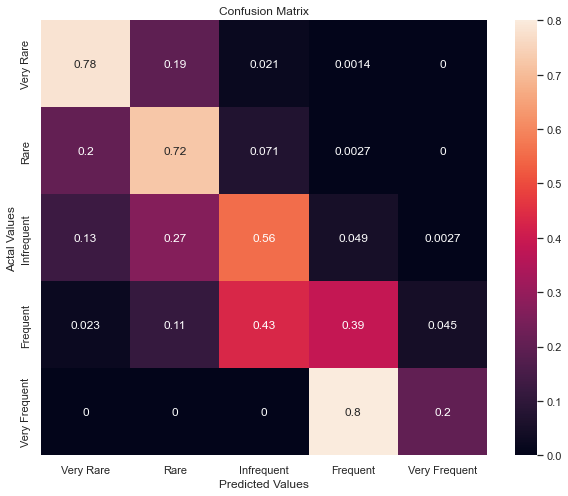

In [100]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_new, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## LightGBM

In [60]:
a = time.time()
param_grid = {'max_depth': [25,50,100], 'n_estimators': [100,250,500,1000]}
grid = GridSearchCV(lgb.LGBMClassifier(class_weight = "balanced"), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Time Taken: 23.96 seconds
Best Estimator: LGBMClassifier(class_weight='balanced', max_depth=50, n_estimators=1000)
Train F1 Score: 0.987581712811499
Test F1 Score: 0.6595776897363577


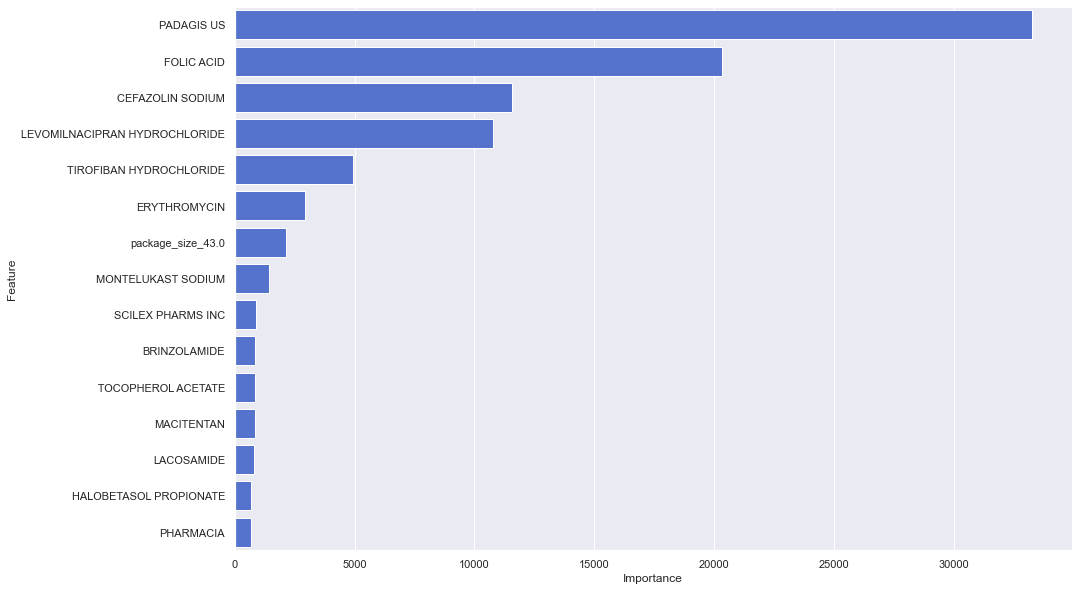

In [61]:
n = 15
indices = (-grid.best_estimator_.feature_importances_).argsort()[:n]
features = columns[indices]
weights = (grid.best_estimator_.feature_importances_)[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(y = 'Feature', x = 'Importance', data = df_temp, color = 'royalblue', orient = 'h');
plt.gcf().set_size_inches(15,10)
#plt.xticks(rotation = 90);

In [62]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_test)
cm_df = pd.DataFrame(cm,
                     index = ['Very Rare','Rare','Infrequent','Frequent','Very Frequent'], 
                     columns = ['Very Rare','Rare','Infrequent','Frequent','Very Frequent'])
cm_df_new = (cm_df.div(cm_df.sum(axis=1), axis=0))

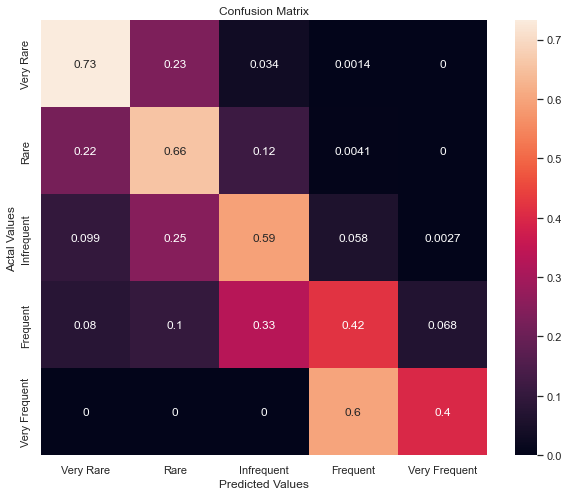

In [63]:
plt.figure(figsize=(10,8))
sns.heatmap(cm_df_new, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

## Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
a = time.time()
param_grid = {'max_iter': [100,500,1000,1500,2000]}
grid = GridSearchCV(LogisticRegression(multi_class = 'multinomial'), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Time Taken: 27.51 seconds
Best Estimator: LogisticRegression(max_iter=500, multi_class='multinomial')
Train F1 Score: 0.3476894201464626
Test F1 Score: 0.34294115872821906


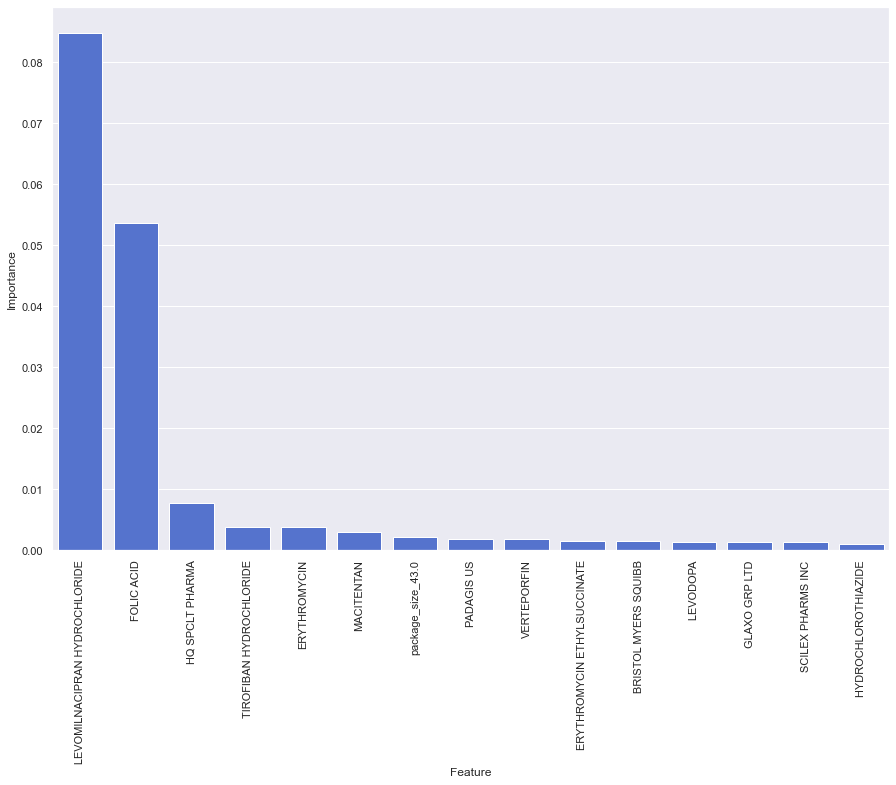

In [65]:
n = 15
indices = (-np.mean(np.abs(grid.best_estimator_.coef_), axis = 0)).argsort()[:n]
features = columns[indices]
weights = (np.mean(np.abs(grid.best_estimator_.coef_), axis = 0))[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(x = 'Feature', y = 'Importance', data = df_temp, color = 'royalblue');
plt.gcf().set_size_inches(15,10)
plt.xticks(rotation = 90);

## SVM Classifier

In [66]:
a = time.time()
param_grid = {'penalty': ['l1', 'l2'], 'max_iter': [500,1000,1500,2000]}
grid = GridSearchCV(LinearSVC(class_weight = "balanced"), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan 0.56029996        nan 0.51895627        nan 0.55644922
        nan 0.57746464]
  category=UserWarning


Time Taken: 4.79 seconds
Best Estimator: LinearSVC(class_weight='balanced', max_iter=2000)
Train F1 Score: 0.7032661370864717
Test F1 Score: 0.5629427773190809


/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


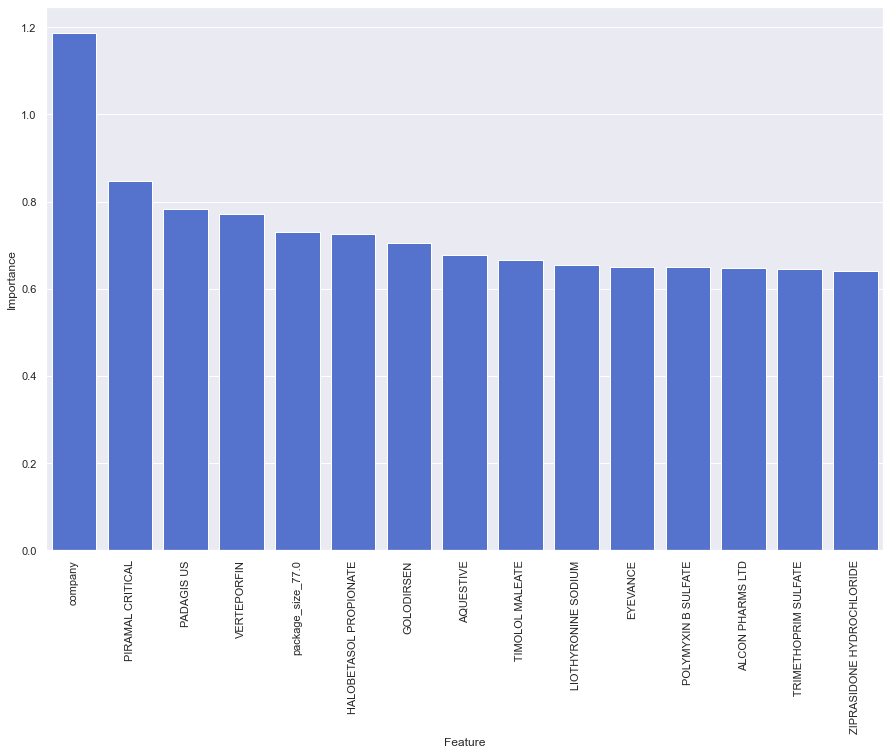

In [67]:
n = 15
indices = (-np.mean(np.abs(grid.best_estimator_.coef_), axis = 0)).argsort()[:n]
features = columns[indices]
weights = (np.mean(np.abs(grid.best_estimator_.coef_), axis = 0))[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(x = 'Feature', y = 'Importance', data = df_temp, color = 'royalblue');
plt.gcf().set_size_inches(15,10)
plt.xticks(rotation = 90);

## KNN

In [68]:
from sklearn.neighbors import KNeighborsClassifier
a = time.time()
param_grid = {'n_neighbors': [2,3,4,5,10,15,20,100]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, refit = True, verbose = 1, n_jobs = -1)
grid.fit(X_train, y_train.ravel())
y_pred_train = grid.predict(X_train)
y_pred_test = grid.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Best Estimator:' + '\033[0m', grid.best_estimator_)
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Time Taken: 7.56 seconds
Best Estimator: KNeighborsClassifier(n_neighbors=2)
Train F1 Score: 0.8234770917891128
Test F1 Score: 0.6136517339103925


## Voting Classifier

In [69]:
from sklearn.naive_bayes import GaussianNB
a = time.time()
clf1 = RandomForestClassifier(class_weight='balanced', max_depth=50, n_estimators=250)
clf2 = lgb.LGBMClassifier(class_weight='balanced', max_depth=30, n_estimators=250)
clf3 = LinearSVC(class_weight='balanced', max_iter=2000)
eclf = VotingClassifier(estimators=[('rf', clf1), ('lgb', clf2), ('svm', clf3)], voting='hard')
eclf.fit(X_train, y_train.ravel())
y_pred_train = eclf.predict(X_train)
y_pred_test = eclf.predict(X_test)
b = time.time()
print('\033[1m' + 'Time Taken:' + '\033[0m', round(b-a, 2), 'seconds')
print('\033[1m' + 'Train F1 Score:' + '\033[0m', f1_score(y_train, y_pred_train, average = 'weighted'))
print('\033[1m' + 'Test F1 Score:' + '\033[0m', f1_score(y_test, y_pred_test, average = 'weighted'))

/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Time Taken: 8.28 seconds
Train F1 Score: 0.9408448124612175
Test F1 Score: 0.6680421810608678


/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_libline

/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", l

/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_libline

/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 238, in fit
    self.loss, sample_weight=sample_weight)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/architmatta/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/svm/_base.py", line 832, in _get_libline

In [153]:
def compute_feature_importance(voting_clf, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if isinstance(est,LinearSVC):
            temp = np.mean(np.abs(est.coef_), axis = 0)
            temp = (temp - np.min(temp))/(np.max(temp) - np.min(temp))
            feature_importance[str(est)] = temp
        else:
            feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return np.asarray(fe_scores)

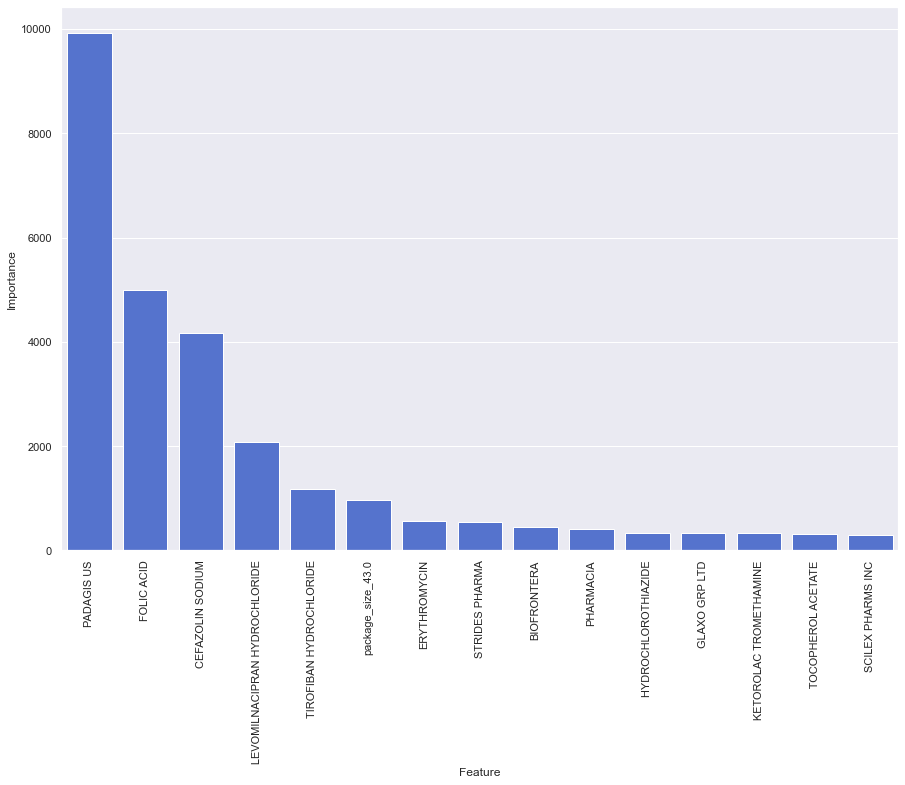

In [155]:
n = 15
indices = (-compute_feature_importance(eclf, [1,1,1])).argsort()[:n]
features = columns[indices]
weights = (compute_feature_importance(eclf, [1,1,1]))[indices]
df_temp = pd.DataFrame({'Feature': features, 'Importance': weights})
sns.barplot(x = 'Feature', y = 'Importance', data = df_temp, color = 'royalblue');
plt.gcf().set_size_inches(15,10)
plt.xticks(rotation = 90);